In [4]:
import json
import os
import sys
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter

abspath = os.path.abspath('.')
while not abspath.endswith('netscope'):
    abspath = os.path.dirname(abspath)
if abspath.endswith('netscope'):
    root_path = abspath
    print(root_path)
    os.chdir(root_path)
    sys.path.append(root_path)

    from analysis.analysis import analysis
    from analysis.utils import wechat_bot
import shutil

/root/netscope/netscope


In [5]:
def rater(exp_kind, rca, answer, version=2):
    exp_kind = exp_kind.rstrip('1234567890')
    # result = {}
    # culprit = rca['culprit']
    if len(answer[exp_kind]) > 1:
        print("answer len:", len(answer[exp_kind]))
    ans = answer[exp_kind][0]
    groundTruth = answer[exp_kind][0]['groundTruth']
    
    if exp_kind == "drop_link":
        rca_df = rca[rca.kind==ans['abnormalKind']]
    else:
        rca_df = rca
        
    for _, row in rca_df.iterrows():
        cul = row.culprit
        correct = False
        if exp_kind == "burst":
            if cul in groundTruth:
                correct = True
                # return row['rank']
        # elif exp_kind == "ecmp_imbalance":
        #     if
        else:
            if cul == groundTruth:
                correct = True
                # return row['rank']
            elif isinstance(groundTruth, list) and cul in groundTruth and not pd.isna(row.suggestion):
                if groundTruth in row.suggestion:
                    correct = True
                    return row['rank']
        
        if correct:
            if row.kind == answer[exp_kind][0]['abnormalKind']:
                return row['rank']
        # break
    return 0

def topk(k, counter):
    return sum([counter.get(i, 0) for i in range(1, k+1)])


class LOG():
    def __init__(self):
        self.msg = ""

    def title(self, t, level=1):
        self.msg += "\n#"*level + " " + str(t).lstrip('\n') + "\n"
        print(t)

    def log(self, s):
        self.msg += str(s) + "\n"
        print(s)
    
    def report(self):
        wechat_bot(self.msg)

    @staticmethod
    def report_fail(data):
        msg = ""
        for exp_kind in exp_kinds:
            if exp_kind not in data: continue
            msg += "# " + exp_kind + '\n'
            msg += str(data[exp_kind]['fail_id']) + '\n'
        wechat_bot(msg)


# rater(exp_kind, rca, answer)

In [10]:
data_path = '/mnt/netscope/data/slot2'
# data_path = '/mnt/netscope/data/slot2/s2l4'
# data_path = "/mnt/netscope/data/slot2/fattree4/"
exp_kinds = os.listdir(data_path)
result_rerca = {}

LOG_flag = True

exp_kinds = ['burst']
# exp_kinds = ['drop_link', 'delay', 'port_queue', ]
# exp_kinds = ['delay']
# exp_kinds = ['drop_link']
# exp_kinds = ['port_queue']
# exp_kinds = ['ecmp_imbalance']


for exp_kind in exp_kinds:
    result_rerca[exp_kind] = {'data': [], 'fail_id': []}
    
    exp_ids = sorted(os.listdir(os.path.join(data_path, exp_kind)))
    print(f"kind: {exp_kind} ({len(exp_ids)})")
    # print(exp_ids)
    # exp_ids = ['20221004_1100GMT']
    
    for i, exp_id in enumerate(exp_ids[:]):
        print(f"-> {i}th", exp_id)
        exp_path = os.path.join(data_path, exp_kind, exp_id)

        with open(os.path.join(exp_path, 'answer.json'), 'r') as f:
            answer = json.load(f)
        
        rca_csv_path = os.path.join(exp_path, 'rca.csv')
        if os.path.exists(rca_csv_path):
            rca = pd.read_csv(rca_csv_path)
            index = rater(exp_kind, rca, answer)
            if 1 == index:
                result_rerca[exp_kind]['data'].append({'id': exp_id, 'rca': rca, 'answer': answer, 'index': index})
                continue
            print("re analysis")
        rca = analysis(data_path=exp_path, log=LOG_flag, verbose=0)

        index = rater(exp_kind, rca, answer)
        if index == 0:
            print('\t[F]', f"{i}th", exp_id)
            result_rerca[exp_kind]['fail_id'].append(exp_id)
        else:
            print(index, exp_id)
            pass
        result_rerca[exp_kind]['data'].append({'id': exp_id, 'rca': rca, 'answer': answer, 'index': index})
    #     break
    # break
LOG.report_fail(result_rerca)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/netscope/data/mars/SZGD/burst'

In [4]:
Log = LOG()
for exp_kind in exp_kinds:
    Log.title(f"\n{exp_kind}")
    L = len(result_rerca[exp_kind]['data'])
    indexs = [data['index'] for data in result_rerca[exp_kind]['data']]
    counts = Counter(indexs)
    Log.log(counts)
    Log.log(f"fail: {counts[0]}/{L} ({counts[0]/L*100:.1f}%)")
    for k in [1, 2, 3, 5, 10]:
        tk = topk(k, counts)
        Log.log(f"top{k}: {tk}/{L} ({tk/L*100:.1f}%)")
        if tk == L: break
Log.report()


burst
Counter({1: 13, 0: 10, 2: 5, 7: 1, 15: 1})
fail: 10/30 (33.3%)
top1: 13/30 (43.3%)
top2: 18/30 (60.0%)
top3: 18/30 (60.0%)
top5: 18/30 (60.0%)
top10: 19/30 (63.3%)


# Old data

In [16]:
# data_path = "/mnt/netscope/data/slot2/fattree4"
data_path = "/mnt/netscope/data/slot2/s2l4"
exp_kinds = os.listdir(data_path)
result = {}
# exp_kinds = ['delay', 'drop_link', 'port_queue3']
exp_kinds = ['burst2', 'ecmp_imbalance']
# # exp_kinds = ['port_queue']
# # exp_kinds = ['delay']
# exp_kinds = ['ecmp_imbalance']
for exp_kind in exp_kinds:
    print(f"kind: {exp_kind}")
    result[exp_kind] = {'data': [], 'fail_id': []}
    for i, exp_id in enumerate(sorted(os.listdir(os.path.join(data_path, exp_kind)))):
        exp_path = os.path.join(data_path, exp_kind, exp_id)
        with open(os.path.join(exp_path, 'answer.json'), 'r') as f:
            answer = json.load(f)
        try:
            rca = pd.read_csv(os.path.join(exp_path, 'rca.csv'))
        except:
            print('no rca.csv', exp_id)
            try:
                rca = analysis(data_path=exp_path, LOG=True, verbose=0)
            except Exception as e:
                print(e)
                # shutil.move(exp_path, exp_path.replace(exp_kind, exp_kind+'_fail'))

        index = rater(exp_kind, rca, answer)
        if index == 0:
            print('\t', i, exp_id, index)
            result[exp_kind]['fail_id'].append(exp_id)
            # if 1:
            #     shutil.move(exp_path, exp_path.replace('burst', 'burst_fail'))
        result[exp_kind]['data'].append({'id': exp_id, 'rca': rca, 'answer': answer, 'index': index})

kind: burst2
	 24 20221005_2007GMT 0
	 35 20221005_2036GMT 0
kind: ecmp_imbalance


In [17]:
for exp_kind in exp_kinds:
    print(f"\nexp_kind: {exp_kind}")
    L = len(result[exp_kind]['data'])
    indexs = [data['index'] for data in result[exp_kind]['data']]
    counts = Counter(indexs)
    print(counts)
    print(f"fail: {counts[0]}/{L} ({counts[0]/L*100:.1f}%)")
    for k in [1, 2, 3, 5, 10]:
        tk = topk(k, counts)
        print(f"top{k}: {tk}/{L} ({tk/L*100:.1f}%)")
        if tk == L: break


exp_kind: burst2
Counter({1: 36, 2: 5, 3: 3, 0: 2, 5: 1, 4: 1})
fail: 2/48 (4.2%)
top1: 36/48 (75.0%)
top2: 41/48 (85.4%)
top3: 44/48 (91.7%)
top5: 46/48 (95.8%)
top10: 46/48 (95.8%)

exp_kind: ecmp_imbalance
Counter({1: 21, 2: 3})
fail: 0/24 (0.0%)
top1: 21/24 (87.5%)
top2: 24/24 (100.0%)


In [7]:
pd_code = 'dict(name="NetScope", '
for k in [1, 2, 3, 5, 10]:
    tk = topk(k, counts)
    pd_code += f"t{k}={tk}/L, "
    if tk == L: break
pd_code = pd_code.rstrip(", ")+"),"
print(pd_code)

exam_score = 0
L_count = 0
for index, count in counts.items():
    if index == 0: continue
    exam_score += (index - 1) * count
    L_count += count
print(exam_score, L_count, exam_score/L_count)

dict(name="NetScope", t1=29/L, t2=31/L, t3=31/L, t5=31/L, t10=31/L),
2 31 0.06451612903225806


20221010_1226GMT 1
20221010_1229GMT 1
20221010_1236GMT 2
20221010_1238GMT 1
20221010_1241GMT 1
20221010_1244GMT 1
20221010_1247GMT 1
20221010_1250GMT 1
20221010_1252GMT 1
20221010_1255GMT 1
20221010_1258GMT 1
20221010_1301GMT 1
20221010_1304GMT 1
20221010_1307GMT 2
20221010_1310GMT 1
20221010_1313GMT 1
20221010_1315GMT 1
20221010_1318GMT 1
20221010_1321GMT 1
20221010_1324GMT 1
20221010_1327GMT 1
20221010_1330GMT 1
20221010_1332GMT 0
20221010_1335GMT 1
20221010_1338GMT 1
20221010_1341GMT 1
20221010_1344GMT 1
20221010_1347GMT 1
20221010_1350GMT 1
20221010_1353GMT 1
20221010_1355GMT 1
20221010_1358GMT 1


ValueError: x and y must be the same size

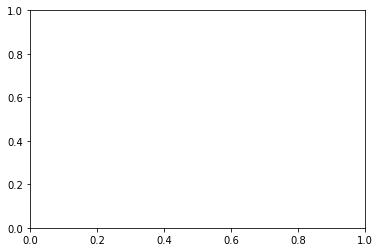

In [8]:
indexes, timeouts = [], []
for data in result[exp_kind]['data']:
    indexes.append(data['index'])
    # timeouts.append(float(data['answer'][exp_kind][0]['cmd'][-1]))
    print(data['id'], data['index'])#, data['answer'][exp_kind][0]['cmd'][-2:])
    # break

fig, ax = plt.subplots()   
plt.scatter(indexes, timeouts, alpha=0.2)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

# Re-RCA

In [ ]:
data = result_rerca[exp_kind]['data'][2]
print(data['id'])
data['rca']

20220411_0239GMT


,general_score,abnormal_pos,abnormal_flow,culprit,kind,suggestion,rank
0,inf,"[s1,]","[s15,s13,s1,s9,s11,, s19,s17,s1,s9,s12,, s11,s...","s1,",switch link,"[s1,s9,]",1.0
1,14.285527,"[s2,s5,]","[s15,s13,s2,s5,s7,]","s2,s5,",switch link,NaN,2.0
2,14.285527,"[s5,s7,]","[s15,s13,s2,s5,s7,]","s5,s7,",switch link,NaN,2.0
3,10.807424,"[s15,s13,]","[s15,s13,s2,s5,s7,, s15,s13,s1,s9,s11,]","s15,s13,",switch link,NaN,3.0
4,7.597316,"[s15,]","[s15,s13,s2,s5,s7,, s15,s13,s1,s9,s11,, s7,s6,...","s15,",switch link,[],4.0
5,6.767991,"[s13,s2,]","[s15,s13,s2,s5,s7,, s16,s13,s2,s17,s20,]","s13,s2,",switch link,NaN,5.0
6,6.185040,"[s7,]","[s15,s13,s2,s5,s7,, s7,s6,s3,s14,s15,, s19,s18...","s7,",switch link,[],6.0
7,4.716770,"[s13,]","[s15,s13,s2,s5,s7,, s15,s13,s1,s9,s11,, s16,s1...","s13,",switch link,[],7.0
8,3.064620,"[s5,]","[s15,s13,s2,s5,s7,, s11,s9,s1,s5,s8,]","s5,",switch link,[],8.0
9,2.049180,"[s9,s11,]","[s15,s13,s1,s9,s11,]","s9,s11,",switch link,NaN,9.0


# single test

In [ ]:
exp_kind = 'delay'
exp_path = f'../experiment/data/{exp_kind}/20220411_0239GMT'
with open(os.path.join(exp_path, 'answer.json'), 'r') as f:
    answer = json.load(f)
rca = analysis(data_path=exp_path, LOG=False, verbose=1)

index = rater(exp_kind, rca, answer)
print(index)

read csv from ../experiment/data/delay/20220411_0239GMT/hosts/INT-MD.csv
2


In [ ]:
rca.head()

,general_score,abnormal_pos,abnormal_flow,culprit,kind,suggestion
0,4.234581,"[s1,]","[s15,s13,s1,s9,s11,, s19,s17,s1,s9,s12,, s11,s...","s1,",switch link,[]
1,4.169105,"[s2,s5,]","[s15,s13,s2,s5,s7,]","s2,s5,",switch link,NaN
2,4.169105,"[s5,s7,]","[s15,s13,s2,s5,s7,]","s5,s7,",switch link,NaN
3,3.075839,"[s15,s13,]","[s15,s13,s2,s5,s7,, s15,s13,s1,s9,s11,]","s15,s13,",switch link,NaN
4,2.464636,"[s7,]","[s15,s13,s2,s5,s7,, s19,s18,s3,s6,s7,, s7,s6,s...","s7,",switch link,[]


# finish

In [ ]:
wechat_bot('exp_result.ipynb')